In [26]:
import numpy as np

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor

X, y = fetch_california_housing(return_X_y=True, as_frame=True)

In [29]:
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# outer_cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)
# inner_cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)

In [44]:
y_oof = np.zeros_like(y)

for i, (outer_train_idx, outer_test_idx) in enumerate(outer_cv.split(X, y), start=1):
    print(f"start outer loop {i}")

    X_outer_train, X_test = X.iloc[outer_train_idx], X.iloc[outer_test_idx]
    y_outer_train, y_test = y.iloc[outer_train_idx], y.iloc[outer_test_idx]

    models = []

    for j, (inner_train_idx, inner_valid_idx) in enumerate(inner_cv.split(X_outer_train, y_outer_train), start=1):
        print(f"start outer loop {i} / inner loop {j}")

        X_inner_train, X_inner_valid = X_outer_train.iloc[inner_train_idx], X_outer_train.iloc[inner_valid_idx]
        y_inner_train, y_inner_valid = y_outer_train.iloc[inner_train_idx], y_outer_train.iloc[inner_valid_idx]

        lgb = LGBMRegressor(
            boosting_type='gbdt',
            n_estimators=1_000
            )

        lgb.fit(
            X=X_inner_train,
            y=y_inner_train,
            eval_set=[(X_inner_train, y_inner_train), (X_inner_valid, y_inner_valid)],
            eval_names=["inner_train", "inner_validation"],
            eval_metric=["rmse"],
            early_stopping_rounds=100,
            verbose=100
        )

        models.append(lgb)

    y_pred = np.zeros_like(y_test)

    for model in models:
        y_pred += model.predict(X_test) / len(models)

    print(f"\n{mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False):.3f}\n")

    y_oof[outer_test_idx] = y_pred

y_oof

start outer loop 1
start outer loop 1 / inner loop 1
Training until validation scores don't improve for 100 rounds.
[100]	inner_train's rmse: 0.390238	inner_train's l2: 0.152286	inner_validation's rmse: 0.448911	inner_validation's l2: 0.201521
[200]	inner_train's rmse: 0.330388	inner_train's l2: 0.109156	inner_validation's rmse: 0.439997	inner_validation's l2: 0.193597
[300]	inner_train's rmse: 0.290744	inner_train's l2: 0.0845321	inner_validation's rmse: 0.436195	inner_validation's l2: 0.190266
[400]	inner_train's rmse: 0.260312	inner_train's l2: 0.0677621	inner_validation's rmse: 0.436221	inner_validation's l2: 0.190289
Early stopping, best iteration is:
[340]	inner_train's rmse: 0.277388	inner_train's l2: 0.0769441	inner_validation's rmse: 0.435007	inner_validation's l2: 0.189231
start outer loop 1 / inner loop 2
Training until validation scores don't improve for 100 rounds.
[100]	inner_train's rmse: 0.384118	inner_train's l2: 0.147547	inner_validation's rmse: 0.479769	inner_validat

array([4.21222494, 4.40972515, 4.42958759, ..., 0.85350287, 0.89163251,
       0.91042655])

In [45]:
mean_squared_error(y_true=y, y_pred=y_oof, squared=False)

0.43714889494386094

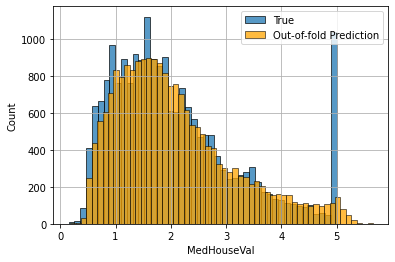

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(y, label="True")
sns.histplot(y_oof, label="Out-of-fold Prediction", color="orange")

plt.legend()
plt.grid(True)
plt.show()